In [104]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

# A. Correlations

In [4]:
full_features <- read_tsv('../../data/task3/4.data/ppi.tsv.xz')
features_df <- read_csv('../../data/prediction_features.csv.xz')

degrees_df <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_a, id_b, edge) %>%
    group_by(id_a) %>%
    mutate(source_degree = sum(edge)) %>%
    ungroup() %>%
    group_by(id_b) %>%
    mutate(target_degree = sum(edge)) %>%
    ungroup() %>%
    select(-edge) %>%
    filter(id_a == id_b) %>%
    mutate(degree = source_degree + target_degree) %>%
    select(id = id_a, degree)

feature_degree_df <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_a, id_b, edge, edge_prior, rwr, jaccard) %>%
    left_join(features_df, by = c("id_a", "id_b")) %>%
    select(-source, -target) %>%
    left_join(degrees_df, by = c("id_a" = "id")) %>%
    left_join(degrees_df, by = c("id_b" = "id")) %>%
    mutate(degree_product = degree.x * degree.y) %>%
    filter(edge == 0 & id_a != id_b) %>%
    sample_n(10000) %>%
    gather('feature', 'value', rwr, jaccard, adamic_adar_index, preferential_attachment, 
           resource_allocation_index) %>%

    mutate(
        feature = feature %>% recode_factor(adamic_adar_index = 'Adamic/Adar index', 
                                            jaccard = 'Jaccard index',
                                            preferential_attachment = 'Preferential attachment\nindex',
                                            resource_allocation_index = 'Resource allocation\nindex',
                                            rwr = 'Random walk\nwith restart',
        )
    )

# Dataframe for annotating correlations onto the facets
correlations <- feature_degree_df %>% 
    group_by(feature) %>%
    summarize(r = cor(degree_product, value, method = 'pearson')) %>%
    mutate(r = r %>% sprintf(fmt = 'r = %.1f'))

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  network = col_character(),
  edge = col_double(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)
Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  adamic_adar_index = col_double(),
  preferential_attachment = col_double(),
  resource_allocation_index = col_double(),
  source = col_double(),
  target = col_double()
)


In [5]:
feature_degree <- feature_degree_df %>%
    ggplot(aes(x = degree_product, y = value)) +
    geom_point(alpha = 0.3) +
    facet_wrap(vars(feature), scales = 'free', nrow = 1) +
    xlab('Product of source and target degree') +
    ylab('Feature value') +
    theme_zietzm() +
    theme(axis.text = element_blank()) +
    geom_text(data = correlations, aes(x = Inf, y = -Inf, label = r), vjust = -0.75, hjust = 1.1)

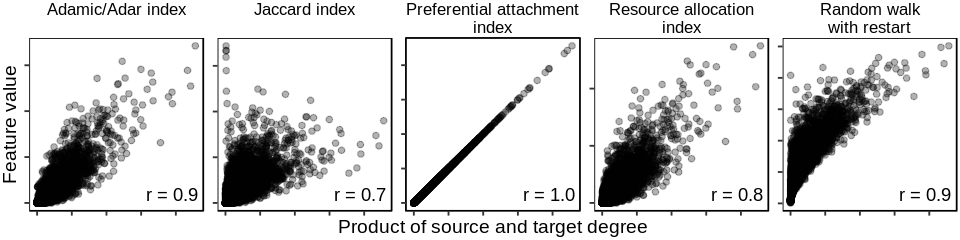

In [11]:
options(repr.plot.width=8, repr.plot.height=2)

feature_degree

# B. Degree assessment

In [42]:
perm_df <- read_csv('../../data/perm_auroc_values.csv') %>%
    gather('feature', 'value', adamic, jaccard, preferential, resource, rwr, edge_prior) %>%
    mutate(feature = feature %>% recode_factor(
        'adamic' = 'Adamic/Adar index', 'jaccard' = 'Jaccard index', 
        'preferential' = 'Preferential attachment\nindex', 'resource' = 'Resource allocation\nindex',
        'rwr' = 'Random walk\nwith restart', 'edge_prior' = 'Edge prior'
    ))


unperm_df <- read_csv('../../data/unperm_auroc_values.csv') %>%
    mutate(edge_prior_copy = edge_prior) %>%
    gather('feature', 'value', adamic, jaccard, preferential, resource, rwr, edge_prior) %>%
    mutate(
        feature = feature %>% recode_factor(adamic = 'Adamic/Adar index', 
                                            jaccard = 'Jaccard index',
                                            preferential = 'Preferential attachment\nindex',
                                            resource = 'Resource allocation\nindex',
                                            rwr = 'Random walk\nwith restart',
                                            edge_prior = 'Edge prior'
        )
    ) %>%
    rename(edge_prior = edge_prior_copy)

Parsed with column specification:
cols(
  metaedge = col_character(),
  adamic = col_double(),
  jaccard = col_double(),
  preferential = col_double(),
  resource = col_double(),
  rwr = col_double(),
  edge_prior = col_double()
)
Parsed with column specification:
cols(
  metaedge = col_character(),
  adamic = col_double(),
  jaccard = col_double(),
  preferential = col_double(),
  resource = col_double(),
  rwr = col_double(),
  edge_prior = col_double()
)


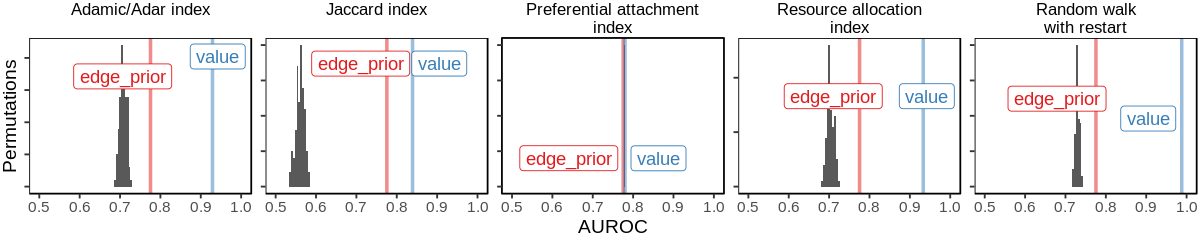

In [109]:
# options(repr.plot.width=12, repr.plot.height=2)

# with_prior <- unperm_df %>% 
# gather('subfeature', 'subvalue', edge_prior, value) %>%
# ggplot() +
# geom_histogram(data = perm_df, aes(x = value), bins = 100) +
# geom_vline(aes(xintercept = subvalue, color = subfeature), size = 1, alpha = 0.5) +
# facet_wrap(vars(feature), scales = 'free_y', nrow = 1) +
# theme_zietzm() +
# xlab('AUROC') +
# ylab('Permutations') +
# scale_color_brewer(palette = 'Set1', labels = c('Edge prior', 'Original network'), name = '') +
# theme(axis.text.y = element_blank(), legend.position = 'none')


options(repr.plot.width=10, repr.plot.height=2)

no_prior <- unperm_df %>% 
gather('subfeature', 'subvalue', edge_prior, value) %>%
filter(feature != 'Edge prior') %>%
ggplot() +
geom_histogram(data = perm_df %>% filter(feature != 'Edge prior'), aes(x = value), bins = 100) +
geom_vline(aes(xintercept = subvalue, color = subfeature), size = 1, alpha = 0.5) +
facet_wrap(vars(feature), scales = 'free_y', nrow = 1) +
coord_cartesian(xlim = c(0.5, 1)) +
theme_zietzm() +
xlab('AUROC') +
ylab('Permutations') +
scale_color_brewer(palette = 'Set1', labels = c('Edge prior', 'Original network'), name = '') +
theme(axis.text.y = element_blank(), legend.position = 'none') +
geom_label_repel(aes(x = subvalue, color = subfeature, label = subfeature, y = 20))

no_prior

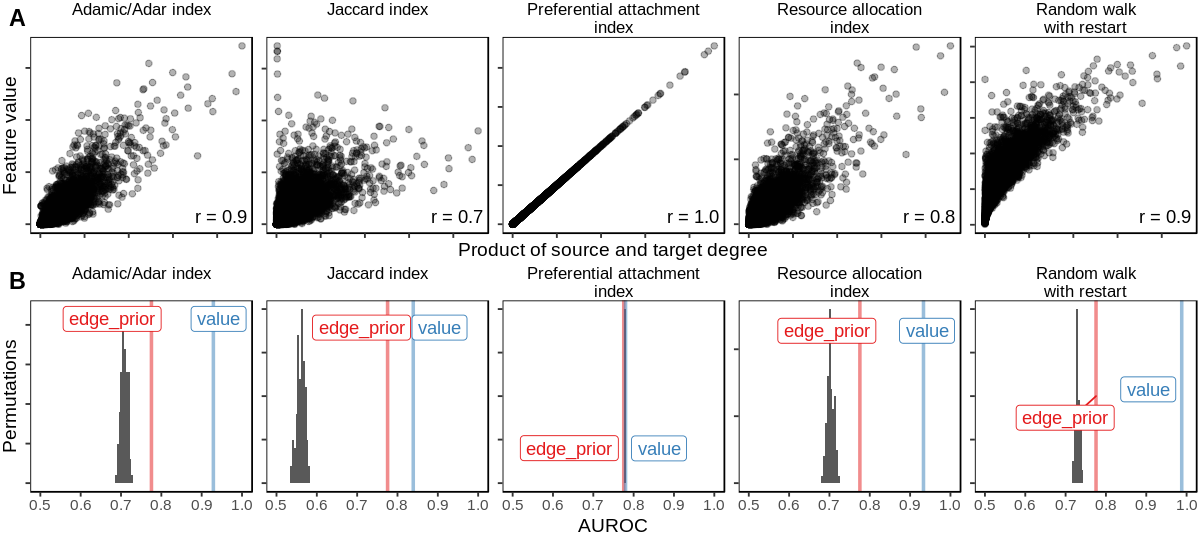

In [112]:
options(repr.plot.width=10, repr.plot.height=4.5)

combined <- plot_grid(feature_degree, no_prior, ncol = 1, labels = c("A", "B"), rel_heights = c(1, 1.05))

ggsave(filename = '../../img/feature_degree_combined.png', combined, width = 10, height = 4.5, dpi = 400)

combined